In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as  plt

Loading Fraud dataset

In [ ]:
df=pd.read_csv('Fraud.csv')

The Cleaning Phase is started

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


Here Dataset has none missing values

In [5]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Here you see dataset has no empty values

In [6]:
import matplotlib.pyplot as plt

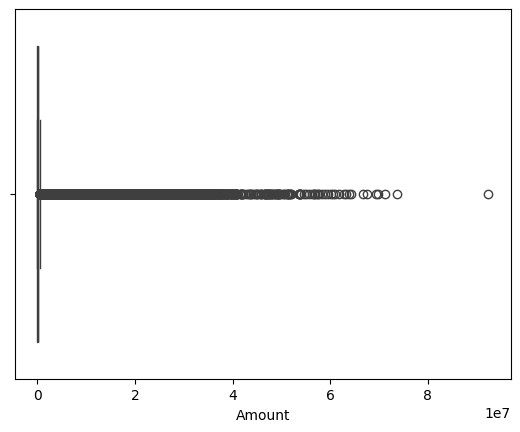

In [7]:
plt.Figure(figsize=(8,6))
sns.boxplot(x=df['amount'])
plt.xlabel("Amount")
plt.show()

Dataset has anamolies or outliers need to overcome them

In [8]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['amount'] < (Q1 - 1.5*IQR)) | (df['amount'] > (Q3 + 1.5*IQR)))]

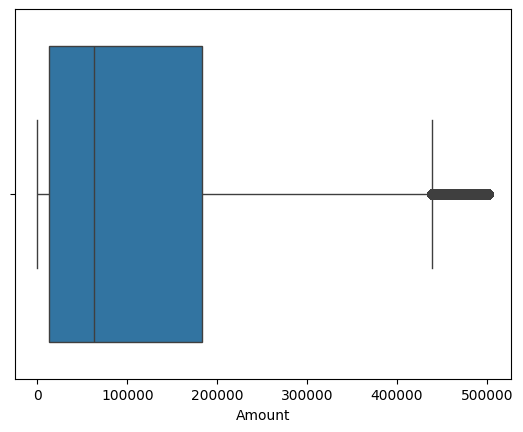

In [9]:
plt.Figure(figsize=(8,6))
sns.boxplot(x=df['amount'])
plt.xlabel("Amount")
plt.show()

No Outliers Dataset is totally clean

In [10]:
df = pd.get_dummies(df, columns=['type'] , drop_first=True)

In [11]:
print(df.duplicated().sum())

0


In [12]:
df = df.drop(['nameOrig','nameDest'], axis=1)
print(df.shape)
print(df.info())

(6024542, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 6024542 entries, 0 to 6362615
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
 7   isFlaggedFraud  int64  
 8   type_CASH_OUT   bool   
 9   type_DEBIT      bool   
 10  type_PAYMENT    bool   
 11  type_TRANSFER   bool   
dtypes: bool(4), float64(5), int64(3)
memory usage: 436.7 MB
None


In [13]:
df = df.astype({
    'type_CASH_OUT' : 'int',
    'type_DEBIT' : 'int',
    'type_PAYMENT' : 'int',
    'type_TRANSFER': 'int'
})

In [14]:
print(df.isnull().sum())

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64


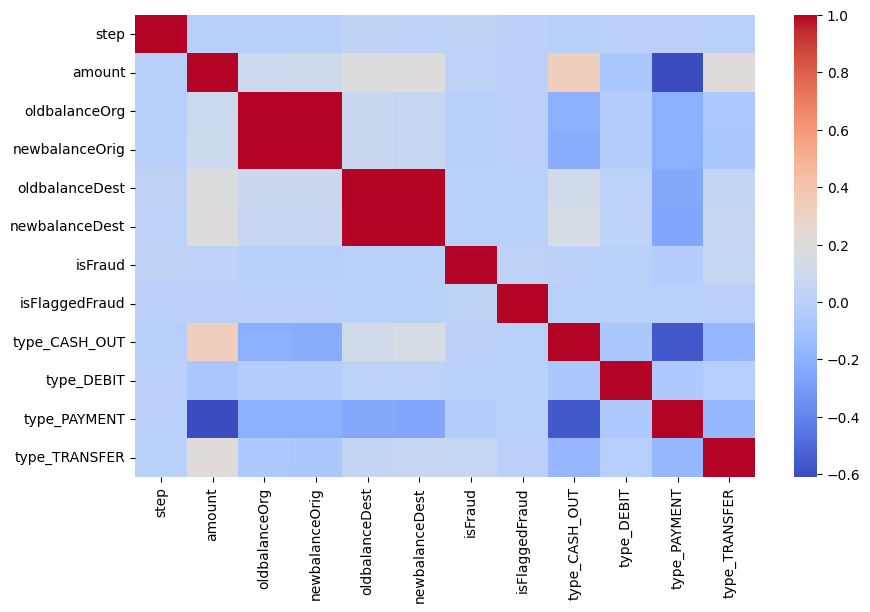

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr() , annot=False , cmap='coolwarm')
plt.show()

Chart show "isFraud" has positive relationship with "type_TRANSFER"

The Model train and test phase is started

In [16]:
from sklearn.model_selection import train_test_split
x = df.drop('isFraud', axis=1)
y = df['isFraud']

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify=y)

print("Train_size : ", x_train.shape , "Train_test : ", x_test.shape )

Train_size :  (4819633, 11) Train_test :  (1204909, 11)


Using LogisticRegression Model as Baseline


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score

In [18]:
model = LogisticRegression(max_iter=1000 , class_weight='balanced')
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:,1]

In [19]:
print("Confusion Matrix : ", confusion_matrix(y_test,y_pred))
print("Classification Reports : ", classification_report(y_test,y_pred))
print("ROC_AUC_Score : ", roc_auc_score(y_test,y_proba))

Confusion Matrix :  [[1154151   49886]
 [      5     867]]
Classification Reports :                precision    recall  f1-score   support

           0       1.00      0.96      0.98   1204037
           1       0.02      0.99      0.03       872

    accuracy                           0.96   1204909
   macro avg       0.51      0.98      0.51   1204909
weighted avg       1.00      0.96      0.98   1204909

ROC_AUC_Score :  0.9942725874466977


Logistic Regression

Precision (fraud = 1): 0.02
→ Out of all frauds predicted, only 2% were actually fraud.
→ Model is basically saying “everything is fraud” to maximize recall.

Recall (fraud = 1): 0.99
→ Catches almost all frauds, but at the cost of too many false positives.

F1-score (fraud = 1): 0.03
→ Very poor balance.

ROC-AUC: 0.994
→ Separation is good, but not reflected in actual predictions because of class imbalance.

In [20]:
import lightgbm as lgb

LightGBM Final Model 

In [21]:
lgbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    class_weight='balanced',
    metric='auc',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=10,
    num_leaves=31,
    random_state=42
    
)

In [22]:
lgbm.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 3487, number of negative: 4816146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 4819633, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Coder : Muhammad Yasir


In [23]:
y_pred = lgbm.predict(x_test)
y_proba = lgbm.predict_proba(x_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[1201893    2144]
 [      9     863]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1204037
           1       0.29      0.99      0.44       872

    accuracy                           1.00   1204909
   macro avg       0.64      0.99      0.72   1204909
weighted avg       1.00      1.00      1.00   1204909


ROC-AUC Score: 0.9987428583433837


LightGBM

Precision (fraud = 1): 0.29
→ ~50% of predicted frauds are correct (HUGE improvement).

Recall (fraud = 1): 0.99
→ Still very high → catching most frauds.

F1-score (fraud = 1): 0.44
→ Balanced trade-off between precision & recall.

ROC-AUC: 0.998
→ Even better separation.

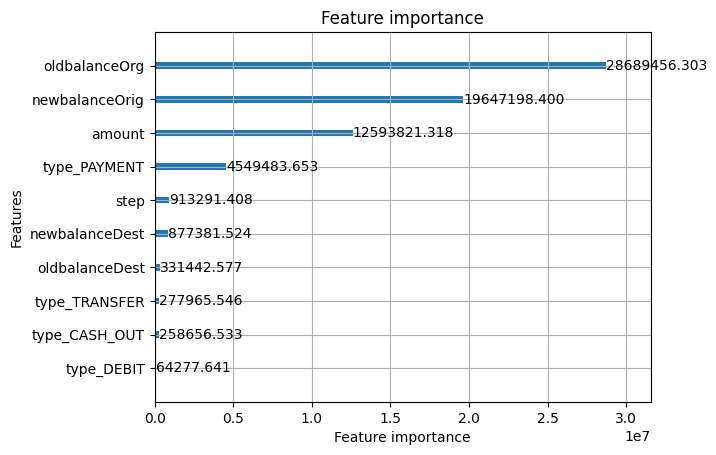

In [24]:


lgb.plot_importance(lgbm, max_num_features=10, importance_type="gain")
plt.show()

"If someone empties their account in a single transaction, it’s highly likely to be fraud."

🔎 What it means when

oldbalanceOrg (highest bar)

This is the sender’s balance before the transaction.

If this feature is most important, it means:
👉 Fraudulent transactions strongly depend on how much money was in the account before sending.

Example: Fraudsters might empty accounts that had large balances.

newbalanceOrig (second highest bar)

This is the sender’s balance after the transaction.

If important, it means:
👉 The model sees fraud when the sender’s account balance drops to zero (very common in fraud cases).

Example: Fraudsters often drain the full balance.

In [25]:

# Run model prediction
y_pred = lgbm.predict(x_test)

# Save results with actual labels
results = x_test.copy()
results["isFraud_Actual"] = y_test
results["isFraud_Predicted"] = y_pred

# Save to CSV for Power BI
results.to_csv("fraud_predictions.csv", index=False)


For Business insights and Q & A see Documentation
